# Invertible Transformation
Ideally, there should be some invertible transformation, when done on the spatial intensity(X) that will generate a vector which can be linearly translated into fetal saturation(Y). Let's say this transformation is 
$$f(X) = M$$
Then there exists some relationship 
$$MN = f_{sat}$$
Where N is some learnable linear transformation. Additionally,
$$f^{-1}(M) = X$$

# Defining the Invertible NN
## Simple Upper Traingular Matrix/No Recombination 

In [1]:
import torch


class INN1(torch.nn.Module):
    """
    A special kind of invertible neural network that has only upper triangular elements in the weight matrix. This makes
    it such the inverse of the network always exists. However, the very last layer is regular linear layer. Internally,
    the non-linear activation is a sigmoid function. As it is invertible as opposed to a ReLU.
    """

    def __init__(self, feature_size: int, total_layer_count: int, output_size: int):
        super().__init__()
        self.feature_size = feature_size
        self.total_layer_count = total_layer_count
        self.output_size = output_size
        self.invertible_layers = []
        for _ in range(total_layer_count - 1):
            self.invertible_layers.append(torch.nn.Linear(feature_size, feature_size))
            self.invertible_layers.append(torch.nn.Sigmoid())
            self.invertible_layers.append(torch.nn.BatchNorm1d(feature_size))
        self.final_layer = torch.nn.Linear(feature_size, output_size)
        self._custom_weight_initialization()  # Upper Traingular weight matrix
        self.layers = self.invertible_layers + [self.final_layer]
        self.model = torch.nn.Sequential(*self.layers)

    def _custom_weight_initialization(self):
        for layer in self.invertible_layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data = torch.triu(layer.weight.data)

    def forward(self, x):
        return self.model(x)


model = INN1(10, 3, 1)
input = torch.randn(32, 10)
output = model(input)

# Test the model output
print("Expected Output Size: 32x1")
print("True Output Size:", output.size())

Expected Output Size: 32x1
True Output Size: torch.Size([32, 1])


In [2]:
import os
import pandas as pd
from typing import Tuple
from model_trainer import ModelTrainer, RandomSplit, DataLoaderGenerator, TorchLossWrapper
from model_trainer.core import DATA_LOADER_INPUT_INDEX

os.environ["CUDA_VISIBLE_DEVICES"] = "3"


class CustomModelTrainer1(ModelTrainer):
    def __init__(self, model, dataloader_gen, validation_method, loss_func):
        super().__init__(model, dataloader_gen, validation_method, loss_func)
        assert hasattr(model, "invertible_layers"), "Model must have the invertible_layers property"

    def single_batch_train_run(self, data: Tuple) -> None:
        inputs = data[DATA_LOADER_INPUT_INDEX]

        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        outputs = self.model(inputs)
        loss = self.loss_func(outputs, data, self.mode)
        loss.backward()

        # Customized Optimize Step -> Convert the gradient to an upper triangular matrix
        for layer in self.model.invertible_layers:
            if isinstance(layer, torch.nn.Linear):
                if layer.weight.grad is not None:
                    layer.weight.grad.data = torch.triu(layer.weight.grad.data)
                else:
                    raise ValueError("Gradient is None")

        self.optimizer.step()

## Test With Dummy Data

In [3]:
# Test The Custom Model Trainer
dummy_data = torch.rand(256, 11)
dummy_data_table = pd.DataFrame(dummy_data.numpy(), columns=[f"Feature_{i}" for i in range(10)] + ["Target"])
feature_columns = [f"Feature_{i}" for i in range(10)]
target_columns = ["Target"]

dataloader_gen = DataLoaderGenerator(dummy_data_table, feature_columns, target_columns, 32, {"shuffle": True})
validation_method = RandomSplit(0.8)
criterion = TorchLossWrapper(torch.nn.MSELoss())

trainer = CustomModelTrainer1(model, dataloader_gen, validation_method, criterion)
trainer.set_optimizer(torch.optim.SGD, {"lr": 1e-3})

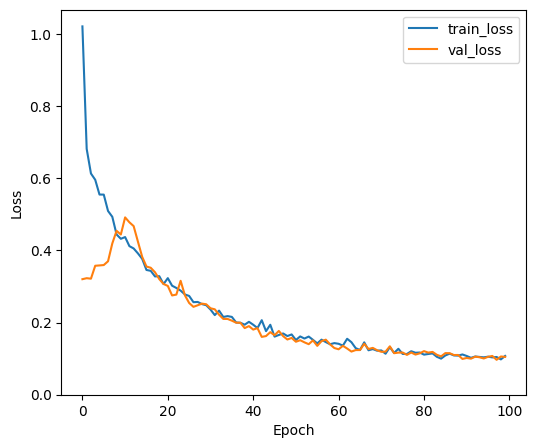

In [4]:
trainer.run(100)
plot_figure = criterion.plot_losses()

# Using Affine Coupling/With Rearrangements
A slightly different type of Invertible NN. These ones have more expressive power compared to using only upper triangular matrices.   

PS: The flips are very non-expressing. Each successive layer operates on different halves of the features!

In [5]:
from typing import Literal


class AffineCouplingLayer(torch.nn.Module):
    def __init__(self, feature_size: int, half_to_transform: Literal["first", "second"], transform_depth: int = 1):
        """
        An affine coupling layer used to compose invertible models.
        :param feature_size: The size of the input(and output) features
        :param half_to_transform: Which half of the input features to transform. Must be either "first" or "second"
        :param transform_depth: The depth of the transformation network. Each layer is a sequence of FC and ReLU
        """
        assert feature_size % 2 == 0, "Feature size must be even"
        super().__init__()
        ## S network
        s_layer_components = []
        for _ in range(transform_depth):
            s_layer_components.append(torch.nn.Linear(feature_size // 2, feature_size // 2))
            s_layer_components.append(torch.nn.ReLU())
        self.s = torch.nn.Sequential(*s_layer_components)

        ## T network
        t_layer_components = []
        for _ in range(transform_depth):
            t_layer_components.append(torch.nn.Linear(feature_size // 2, feature_size // 2))
            t_layer_components.append(torch.nn.ReLU())
        self.t = torch.nn.Sequential(*t_layer_components)

        ## Transform indices
        self.half_to_transform = half_to_transform
        self.transform_indices = (
            slice(0, feature_size // 2) if half_to_transform == "first" else slice(feature_size // 2, feature_size)
        )

    def forward(self, x):
        ## Transformed half
        x_t = self.t(x[:, self.transform_indices])
        x_s = self.s(x[:, self.transform_indices])

        ## Identity half
        res = x.clone()
        # res[:, self.transform_indices] = torch.exp(x[:, self.transform_indices] * x_s) + x_t  # Exp path
        res[:, self.transform_indices] = x[:, self.transform_indices] * x_s + x_t    # Non-exp path
        x = res
        return x


class INN2(torch.nn.Module):
    """
    An invertible NN that uses affine coupling transformation. The network is split into two parts. The first part
    is a simple feedforward network that produces the scaling and translation parameters. The second part is the
    affine coupling transformation. This ensures the model is always invertible
    """

    def __init__(self, feature_size: int, total_layer_count: int, output_size: int, transform_depth: int = 1):
        """
        :param feature_size: The size of the input features
        :param total_layer_count: The total number of Affine Coupling Layers in the model
        :param output_size: The size of the output features at the end of the final FC layer
        :param transform_depth: The depth of each indivdiual transformation network inside the Affine Coupling Layer
        """
        super().__init__()
        self.feature_size = feature_size
        self.total_layer_count = total_layer_count
        self.output_size = output_size
        self.layers = []
        for i in range(total_layer_count - 1):
            if i % 2 == 0:
                self.layers.append(AffineCouplingLayer(feature_size, "first", transform_depth))
            else:
                self.layers.append(AffineCouplingLayer(feature_size, "second", transform_depth))
            self.layers.append(torch.nn.BatchNorm1d(feature_size))
        self.layers.append(torch.nn.Linear(feature_size, output_size, bias=False))  # Final Layer
        # self.layers.append(torch.nn.Tanh())         # Ends in tanhh - Failed Experiment
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)


# Test the Affine Coupling Layer
feature_size = 10
half_to_transform = "first"
layer = AffineCouplingLayer(feature_size, half_to_transform)
input = torch.randn(32, feature_size)
output = layer(input)
print("Affine Output Size", output.size())

# Test the INN2
model = INN2(10, 5, 1)
input = torch.randn(32, 10)
output = model(input)
print("Model Output Size", output.size())

Affine Output Size torch.Size([32, 10])
Model Output Size torch.Size([32, 1])


## Testing With Dummy Data

In [6]:
import os
import pandas as pd
from model_trainer import ModelTrainer, RandomSplit, DataLoaderGenerator, TorchLossWrapper

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Test The Custom Model Trainer
dummy_data = torch.rand(256, 11)
dummy_data_table = pd.DataFrame(dummy_data.numpy(), columns=[f"Feature_{i}" for i in range(10)] + ["Target"])
feature_columns = [f"Feature_{i}" for i in range(10)]
target_columns = ["Target"]

dataloader_gen = DataLoaderGenerator(dummy_data_table, feature_columns, target_columns, 32, {"shuffle": True})
validation_method = RandomSplit(0.8)
criterion = TorchLossWrapper(torch.nn.MSELoss())

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)
trainer.set_optimizer(torch.optim.SGD, {"lr": 1e-3})

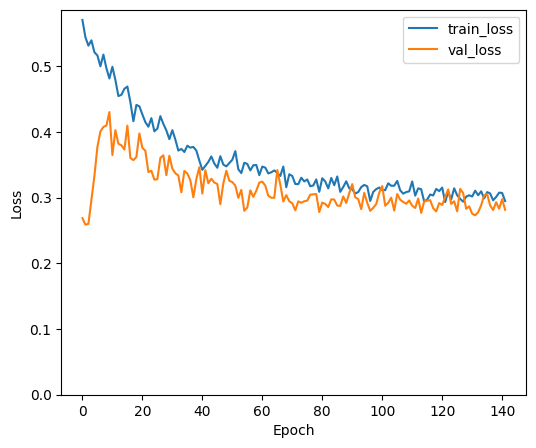

In [7]:
trainer.run(200)
loss_plot = criterion.plot_losses()

# Testing On Simulation Data

In [8]:
import json
from pathlib import Path

file_name1 = 'I1_and_I2_interp'
file_name2 = 'pulsation_ratio'

# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.pkl"
data1 = pd.read_pickle(DATA_PATH)
# DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.pkl"
# data2 = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.json"
with open(CONFIG_PATH, "r") as f:
    config1 = json.load(f)
# CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.json"
# with open(CONFIG_PATH, "r") as f:
    # config2 = json.load(f)
labels = config1["labels"]  # Should have the same labels
intensity = config1["features"]
# pulsation_ratio = config2["features"]

# data = pd.merge(data1, data2, on=labels, how="inner")
data = data1.copy()

# Cleanup
data.dropna(inplace=True)
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 4.0)
    & (data["Maternal Wall Thickness"] <= 25.0)
]

from inverse_modelling_tfo.features.build_features import TwoColumnOperationFeatureBuilder

i1_wv2 = intensity[:len(intensity)//4]
i1_wv1 = intensity[len(intensity)//4:2*len(intensity)//4]
i2_wv2 = intensity[2*len(intensity)//4:3*len(intensity)//4]
i2_wv1 = intensity[3*len(intensity)//4:]


# Create the feature builders
fb1 = TwoColumnOperationFeatureBuilder(i2_wv1, i1_wv1, '/', False, intensity, labels)
fb2 = TwoColumnOperationFeatureBuilder.from_chain(fb1, i2_wv2, i1_wv2, '/', False)

# Transform the data
data = fb2(data)

features = fb2.get_feature_names()


print("training with", len(data), "samples")

training with 365904 samples


In [9]:
from sklearn import preprocessing 

x_columns = features
y_columns = ["Fetal Saturation"]

y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [38]:
from model_trainer import HoldOneOut, ModelTrainerNoisy


dataloader_gen = DataLoaderGenerator(data, x_columns, y_columns, 32, {"shuffle": True})

## Validation Methods
# Path 1
# validation_method = RandomSplit(0.7)
# Path 2
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut('Maternal Wall Thickness', all_depths[len(all_depths)//2])

## Crierion
criterion = TorchLossWrapper(torch.nn.MSELoss())
# criterion = TorchLossWrapper(torch.nn.HuberLoss(delta=0.5))
# criterion = TorchLossWrapper(torch.nn.L1Loss())

## Model
# model = INN2(len(x_columns), 5, len(y_columns))     # Absolute best results!
model = INN2(len(x_columns), 4, len(y_columns), 3)     
# model = INN1(len(x_columns), 4, len(y_columns))     

## Trainers
# trainer = CustomModelTrainer1(model, dataloader_gen, validation_method, criterion)
# trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)
trainer = ModelTrainerNoisy(model, dataloader_gen, validation_method, criterion, list(range(len(x_columns))), [0.01] * len(x_columns), [0.0] * len(x_columns))

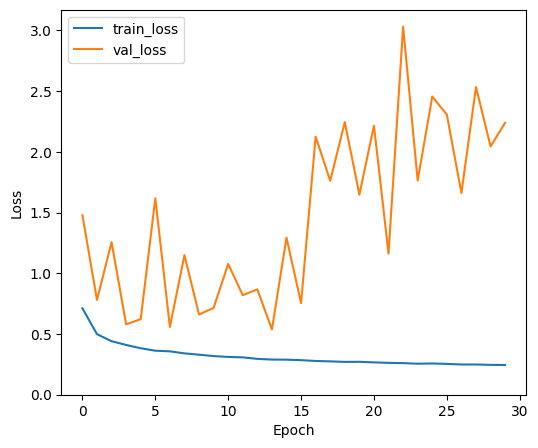

In [39]:
## Model Training
# trainer.set_batch_size(1024)    # Absolute best results!
trainer.set_batch_size(2048)    
# trainer.set_optimizer(torch.optim.SGD, {"lr": 8e-4, 'momentum': 0.9, 'nesterov': True})     # Absolute best results!
trainer.set_optimizer(torch.optim.SGD, {"lr": 4e-3, 'momentum': 0.89, 'nesterov': True})    
trainer.run(30)
loss_plot = criterion.plot_losses()

In [40]:
mse_console = criterion.print_table()

               Losses                
┏━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ 👀 ┃ Train Loss ┃ Validation Loss ┃
┡━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│    │   0.2447   │     2.2390      │
└────┴────────────┴─────────────────┘

In [41]:
import torchinfo
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
INN2                                     --
├─Sequential: 1-1                        --
│    └─AffineCouplingLayer: 2-1          --
│    │    └─Sequential: 3-1              1,260
│    │    └─Sequential: 3-2              1,260
│    └─BatchNorm1d: 2-2                  80
│    └─AffineCouplingLayer: 2-3          --
│    │    └─Sequential: 3-3              1,260
│    │    └─Sequential: 3-4              1,260
│    └─BatchNorm1d: 2-4                  80
│    └─AffineCouplingLayer: 2-5          --
│    │    └─Sequential: 3-5              1,260
│    │    └─Sequential: 3-6              1,260
│    └─BatchNorm1d: 2-6                  80
│    └─Linear: 2-7                       40
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0

# Error Distribution and Visualization

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from inverse_modelling_tfo.visualization.tables import create_filtered_error_stats_table
from inverse_modelling_tfo.visualization.visualize import plot_performance_distributions
import matplotlib.pyplot as plt

mae_console = create_filtered_error_stats_table(data, x_columns, y_columns, y_scaler, trainer.model, "Maternal Wall Thickness", "mae", validation_method)

                                   Error Statistics                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Maternal Wall Thickness ┃ Train Mean ┃ Train Std ┃ Validation Mean ┃ Validation Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ 4.0                     │     0.0529 │    0.0060 │             N/A │            N/A │
│ 5.0                     │     0.0372 │    0.0077 │             N/A │            N/A │
│ 6.0                     │     0.0357 │    0.0069 │             N/A │            N/A │
│ 7.0                     │     0.0297 │    0.0083 │             N/A │            N/A │
│ 8.0                     │     0.0380 │    0.0138 │             N/A │            N/A │
│ 9.0                     │     0.0119 │    0.0094 │             N/A │            N/A │
│ 10.0                    │     0.0429 │    0.0203 │             N/A │            N/A │
│ 11.0                    │     0.0465 │    0.0133 │             N/A │            N/A │
│ 12.0                    │     0.0359 │    0.0158 │             N/A │            N/A │
│ 13.0                    │     0.0255 │    0.0150 │             N/A │            N/A │
│ 14.0                    │     0.0227 │    0.0161 │             N/A │            N/A │
│ 15.0                    │        N/A │       N/A │          0.1548 │         0.0931 │
│ 16.0                    │     0.0347 │    0.0311 │             N/A │            N/A │
│ 17.0                    │     0.0693 │    0.0448 │             N/A │            N/A │
│ 18.0                    │     0.0714 │    0.0490 │             N/A │            N/A │
│ 19.0                    │     0.0604 │    0.0442 │             N/A │            N/A │
│ 20.0                    │     0.0708 │    0.0490 │             N/A │            N/A │
│ 21.0                    │     0.0667 │    0.0469 │             N/A │            N/A │
│ 22.0                    │     0.0810 │    0.0575 │             N/A │            N/A │
│ 23.0                    │     0.0686 │    0.0478 │             N/A │            N/A │
│ 24.0                    │     0.0745 │    0.0499 │             N/A │            N/A │
│ 25.0                    │     0.0932 │    0.0589 │             N/A │            N/A │
└─────────────────────────┴────────────┴───────────┴─────────────────┴────────────────┘

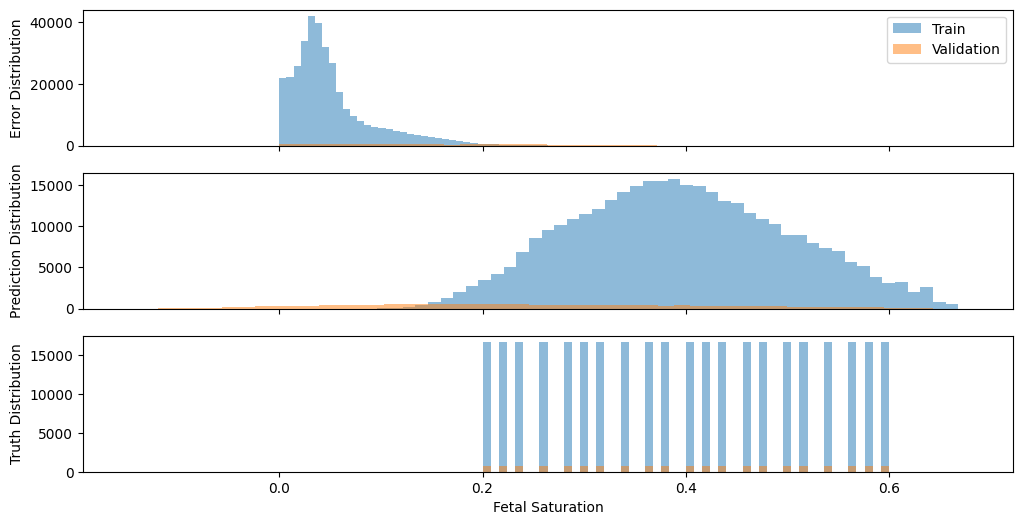

In [44]:
distribution_plot = plot_performance_distributions(
    data, x_columns, y_columns, y_scaler, trainer.model, None, "mae", validation_method
)
plt.show()

In [45]:
# print("Printing MAE Errors...")
# mae_console = create_error_stats_table(train_error, val_error)

## Personal Notes

### Training Notes
1. Batch Size: (Assuming lr is fixed around 3e-4) for smaller batch size, the validation error is astronomically large! Only for larger batch sizes do you start seeing the model perform really well. Best results were for 1024. But Increasing batchsize to 2048 (layer count=5), reduces MSE at the cost of MAE. Whereas the network produces thes egregious outliers in prediction. But the MSE continues to decline! Maybe Huber loss is a better criterion
2. Affine Coupling Layer Count: Lower number -> Model is not expressive enough to capture the data. The errors stagnate at a certain value. Though it still learns. I got the best results for Layer Count = 5 (With 4 still giving decent results as well)
3. SGD Optimizer: Nestrov momemntum calculation: True, Momentum: 0.9
4. Large Coupling Layer Count: The network has this weird behaviour where if the layer count is too high (>5), the gradients explode. NaNs in results! :(
5. Loss Func: MSE seems to optimize best. 
6. BatchNorm layers seem to break the model. The training becomes a lot more unstable, even when it trains, you get worse results. 
7. Validation Depth: Even with a different depths as the validation - model still holds similar performace
8. Training with Noisy Input: Keeps the validation coupled/lower than training at the cost of making the training loss high. It feels like even tiny bits of noise (STD: 0.1) makes the model hard to train. Training with noise of 0.01 STD seems to give slightly better results. But from a theoretical standpoint, it makes proper sense to me. Maybe train longer. Ideally, the transformations should be noise tolerant. As in, a small change in the input should only produce a small change in the output vector (The penultimate layer - not just the final saturation).
9. Ending in Tanh: A pattern I keep on observing is the predictions made outside the bounding ranges of 10% to 60%. These predictions make up the very large(but tiny in quantity) error points. I tried ending the model with a TanH layer to force the outputs to become in that -1 to +1 range(Before unscaling). But this seems to impact the expressiveness of the model - Leading to worse results overall. Even for those bad points, it would lump at the edge saturation values. not super useful.
10. No Bias in Final FC Layer - Works! Comparable performance!


### Things to Try
1. Increase the depth values range
2. Is the exp( ) term - from the original GLOW paper - actually necessary? I have the exp() in code. Try without it.
3. Check which combo of tmps produce these large error points. How can we remove them
4. Looking at the vector right before the final linear layer should give us enough information about OOD. Can be a good tool determine if a specific datapoint has high confidence or not
5. What is the minimum number of channels required for this

In [46]:
# from mdreport import MarkdownReport
# from pathlib import Path

# report = MarkdownReport(Path(r'reports/'), 'report4', 'Performance of Affine Coupling Invertible Neural Network')
# report.add_text_report('Objective', 'Similar to Report3 - Except no noise was added during training!')
# report.add_image_report('Training Curves', loss_plot)
# report.add_rich_text_report('MSE Errors (Normalized)', mse_console)
# report.add_rich_text_report('MAE Errors (Unscaled)', mae_console)
# report.add_image_report('Error Distribution', distribution_plot)
# report.add_code_report('Trainer Details', str(trainer))
# report.save_report()